## Why do we need Mask Detection?
In these uncertain times, human civilization needs to quickly adapt to the threat at hand. While wearing mask is not the ultimate solution, it still reduces the rate of transmission of the virus. For us, to create such safe ecosystem, we need techniques like Mask Detection to ensure that the rate of transmission is controlled in highly crowded public spaces and other areas where risk of transmission is high.

In this notebook, following process is adopted:
* Step1: Extract the face data for training.
* Step2: Train the classifier to classify faces into mask or non-mask labels.
* Step3: Detect Faces in testing data using SSD Face Detector.
* Step4: By using the trained classifier, classify the detected faces.

## Content
1. [Importing Libraries and Directories](#section-one)<br>
2. [What is SSD?](#section-two)<br>
3. [Functions](#section-three) <br>
4. [Data Preprocessing](#section-four)<br>
5. [Model Architecture and Training Process](#section-five)<br>
6. [Training and Validation Visualizations](#section-six)<br>
7. [Model Testing](#section-seven)<br>
8. [Conclusion](#section-eight)<br>

<a id="section-one"></a>
## Importing Libraries and Directories

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
directory = "/content/drive/MyDrive/Face Mask Detection/archive/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "/content/drive/MyDrive/Face Mask Detection/archive/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("/content/drive/MyDrive/Face Mask Detection/archive/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Face Mask Detection/archive/submission.csv")

<a id="section-two"></a>
## What is SSD?
SSD is **Single Shot Multibox Detector**. It is a technique that is used to detect objects in images using a single deep neural network. Basically its used for object detection in an image. By using a **base architecture of VGG-16 Architecture**, SSD is able to out perform other object detectors like YOLO and Faster R-CNN in both speed and accuracy. The architecture of SSD is given in the figure below. Training a SSD model from scratch will require a lot of data, so here I have imported pretrained weights **(Caffe Face Detector Model)** using OpenCV.

![SSD Architecture](https://www.researchgate.net/profile/Adam_Nowosielski/publication/332948824/figure/fig5/AS:767146284036100@1559913335810/The-model-of-Single-Shot-MultiBox-Detector-SSD-25.ppm)

In [3]:
cvNet = cv2.dnn.readNetFromCaffe('/content/drive/MyDrive/Face Mask Detection/caffe-face-detector-opencv-pretrained-model/architecture.txt','/content/drive/MyDrive/Face Mask Detection/caffe-face-detector-opencv-pretrained-model/weights.caffemodel')

<a id="section-three"></a>
## Functions 
1. JSON Function fetches the json file that has the data of bounding box in the training dataset.
2. Gamma correction, or often simply gamma, is a nonlinear operation used to encode and decode luminance or tristimulus values in video or still image systems. In simple terms it is used to instill some light in the image. If gamma < 1, image will shift towards darker end of the spectrum and when gamma > 1, there will be more light in the image.

In [4]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

In [5]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

<a id="section-four"></a>
## Data Preprocessing 

Lets look at the JSON data given for training:
* The Annotations field contains the data of all the faces present in a particular image.
* There are various classnames but the true classnames are **face_with_mask** and **face_no_mask**.

In [6]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'Annotations': [{'Attributes': {},
   'BoundingBox': [96, 0, 430, 432],
   'Confidence': 1,
   'ID': 964820035886422400,
   'classname': 'face_with_mask',
   'isProtected': False},
  {'Attributes': {},
   'BoundingBox': [119, 219, 411, 430],
   'Confidence': 1,
   'ID': 571368820964801024,
   'classname': 'mask_surgical',
   'isProtected': False},
  {'Attributes': {},
   'BoundingBox': [77, 49, 480, 500],
   'Confidence': 1,
   'ID': 131405119765588880,
   'classname': 'face_shield',
   'isProtected': False}],
 'FileName': '5317.jpg',
 'NumOfAnno': 3}

In [7]:
df = pd.read_csv("/content/drive/MyDrive/Face Mask Detection/archive/train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


* By using the mask label and non_mask label, the bounding box data from json files is extracted.
* The faces from any particular image are extracted and stored in the data list along with its label for the training process.

In [8]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)    

In [9]:
len(data)

5749

* The visualization below tells us that the **Number of Mask images > Number of Non-Mask images**, so this is an imbalanced dataset. But since we are using a SSD pretrained model, which is trained to detect non-mask faces, this imbalance would not matter a lot.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


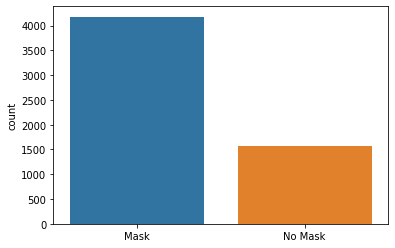

In [10]:
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

In [11]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)


In [12]:
X[0].shape

(124, 124, 3)

In [13]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [14]:
np.unique(Y)

array([0, 1])

In [15]:
Y.shape

(5749,)

<a id="section-five"></a>
## Model Architecture and Training Process 

In [16]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

In [19]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [ ]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=100,
                    verbose=1,
                    validation_data=(xval, yval))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
143/143 [==============================] - 48s 114ms/step - loss: 0.4221 - accuracy: 0.8033 - val_loss: 0.2354 - val_accuracy: 0.9174
Epoch 2/100
143/143 [==============================] - 15s 107ms/step - loss: 0.2641 - accuracy: 0.8906 - val_loss: 0.2619 - val_accuracy: 0.8913
Epoch 3/100
143/143 [==============================] - 15s 108ms/step - loss: 0.2747 - accuracy: 0.8918 - val_loss: 0.2118 - val_accuracy: 0.9209
Epoch 4/100
143/143 [==============================] - 16s 109ms/step - loss: 0.2479 - accuracy: 0.8973 - val_loss: 0.2061 - val_accuracy: 0.9130
Epoch 5/100
143/143 [==============================] - 15s 107ms/step - loss: 0.2445 - accuracy: 0.8983 - val_loss: 0.2194 - val_accuracy: 0.9174
Epoch 6/100
143/143 [==============================] - 15s 107ms/step - loss: 0.2327 - accuracy: 0.9037 - val_loss: 0.2204 - val_accuracy: 0.9096
Epoch 7/100
143/143 [==============================] - 15s 106ms/step - loss: 0.2164 - accuracy: 0.9088 - val_loss: 0.1749 -

<a id="section-six"></a>
## Training and Validation Visualizations

In [ ]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<a id="section-seven"></a>
## Model Testing 

The test dataset has 1698 images and to evaluate the model I have taken a handful of images from this dataset as there are no labels for faces in the dataset. 

In [ ]:
print(len(df_test["name"]),len(df_test["name"].unique()))

In [ ]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

* Gamma Correction for making the image appear in more light.**(Gamma = 2)**
* blobFromImage creates 4-dimensional blob from image. Optionally resizes and crops image from center, subtract mean values, scales values by scalefactor, swap Blue and Red channels. [Refer OpenCV documentation]
* The blob is passed through the SSD network and detections are made with some confidence score.
* Define a threshold confidence score, above which the detection will be considered as a candidate of being a face. (In this case **confidence threshold = 0.2**)
* All the detections that qualify the confidence score are then passed to the architecture for classification into mask or non-mask image.

In [ ]:
gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

<a id="section-eight"></a>
## Conclusion
By analyzing the results it can be observed that the whole system works well for faces that have spatial dominance i.e. in image at (1,1), (1,2) and (2,1) but fails in case of (2,2) where the faces are small and occupy less space in the overall image. **To get better results, different image preprocessing techniques can be used, or confidence threshold can be kept lower, or one can try different blob size.**